# Transformers for abstractive summarization

In this notebook, we use the transformers model to predict abstractive summary of an article.
\
Transformers are the current state-of-the-art type of models for dealing with sequences. They are commonly used for text processing tasks, such as machine translation and Summurization.

Unlike previous state-of-the-art architectures for NLP, such as the many variants of RNNs and LSTMs, there are no recurrent connections and thus no real memory of previous states. Transformers to compensate this lack of memory by processing entire sequences simultaneously. Future elements in the sequence are usually masked out during training, but other than that the model is free to learn long-term semantic dependencies throughout the entire sequence.

More about transformers in detail could be found in https://towardsdatascience.com/a-deep-dive-into-the-transformer-architecture-the-development-of-transformer-models-acbdf7ca34e0

This picture explains the general structure of transformers:
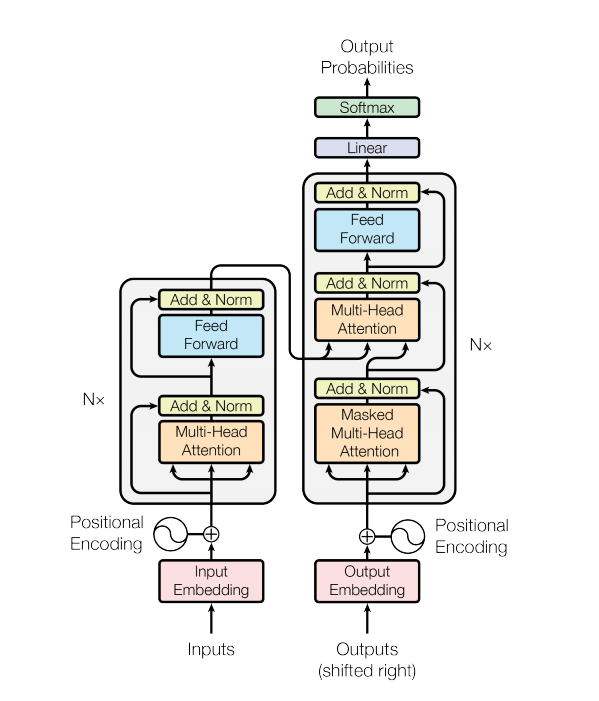

# Imports

In [2]:
!pip install py-rouge
import os
os.chdir("/content/drive/MyDrive/Text summarization")
from imports import *
from Preprocess import *
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))

     |████████████████████████████████| 61kB 4.9MB/s 
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


We import the original data version and we will apply a different clean than the one for the extractive approach because ponctuation in sequential models is important.

# Data preprocessing

## Data clean

In [ ]:
data=pd.read_csv('data/Text summarization data.csv')
sentence_tokens= data.article_text.apply(sentence_tokenizer)
data["article_sentence_count"]=[element[1] for element in sentence_tokens]
summary_sentence_tokens= data.summary_text.apply(sentence_tokenizer)
data["summary_sentence_count"]=[element[1] for element in summary_sentence_tokens]

In [ ]:
data = filter_articles(data)
with open('data/transformations2.json') as f:
  transformations2 = json.load(f)
t = time()
#create pre-processed data
data['article_text']= data["article_text"].apply(lambda x: clean_text2(x, transformations2))

data['summary_text']= data["summary_text"].apply(lambda x: clean_text2(x,transformations2))

print('Time to clean up articles and summaries: {} mins'.format(round((time() - t) / 60, 2)))

In [ ]:
data["article_character_count"]=data.article_text.apply(len)
data["article_word_count"]=data.article_text.apply(num_tokens_without_punctuation)
data["summary_character_count"]=data.summary_text.apply(len)
data["summary_word_count"]=data.summary_text.apply(num_tokens_without_punctuation)

In [ ]:
data.to_pickle("data/corpus_dataframe2.pkl")

In [ ]:
with open('data/corpus_dataframe2.pkl', 'rb') as f:
  data = pickle.load(f)
data.head()

,article_text,summary_text,article_sentence_count,summary_sentence_count,article_character_count,article_word_count,summary_character_count,summary_word_count
1,usain bolt rounded off the world championships...,usain bolt wins third gold of world championsh...,19,4,3215,316,179,19
2,"the general services administration , already ...",the employee in agency kansas city office is a...,42,3,6222,550,246,23
3,"a medical doctor in vancouver , british columb...",new : a canadian doctor says she was part of a...,41,4,5863,537,327,36
4,"police arrested another teen thursday , the si...",another arrest made in gang rape outside calif...,14,3,1712,168,214,25
5,thousands on saturday fled the area in southwe...,"humanitarian groups expect 4,000 refugees in o...",28,3,3510,314,225,20


## Tokenizing

\
We add '< go >' and '< stop >' tokens at the beginning and end of each summary. 
\
The articles and summaries are converted to numeric sequences to transform entries into numerical entries.
\
Which means  a text sequence can be transformed into numerical vector, and vice-versa. Of course the process is limited by the dictionnary limit.

In [ ]:
articles=data["article_text"]
summaries=data["summary_text"]
summaries = summaries.apply(lambda x: '<go> ' + x + ' <stop>')

#adding a filter to ignore the characters below if they exist
filters='"#$%&()*+-/=@[\\]^_`{|}~\t\n'
oov_token = '<unk>' #used to identify unknown words in the vocabulary
#create text tokenizers
article_tokenizer = tf.keras.preprocessing.text.Tokenizer(oov_token=oov_token, filters=filters)
summary_tokenizer = tf.keras.preprocessing.text.Tokenizer( oov_token=oov_token, filters=filters)
#fit the transformers
article_tokenizer.fit_on_texts([article for article in articles])
summary_tokenizer.fit_on_texts([summary for summary in summaries])
#convert articles and summaries to numerical entries
num_art = article_tokenizer.texts_to_sequences(articles)
num_summ = summary_tokenizer.texts_to_sequences(summaries)

Let's test the tokenizers

In [ ]:
article_tokenizer.texts_to_sequences(["convert this sentence    , to numbers ."])

[[7963, 31, 1321, 3, 5, 1143, 4]]

The opposite procedure:

In [ ]:
article_tokenizer.sequences_to_texts([[7963, 31, 1321, 3, 5, 1143, 4]])

['convert this sentence , to numbers .']

Let us replace a word by another irrelevant term that doesnot exist in the disctionnary and check again

In [ ]:
article_tokenizer.texts_to_sequences(["doesnotexist this sentence ?"])

[[1, 31, 1321, 76]]

If multiple entries are given, a matrix is returned

In [ ]:
article_tokenizer.texts_to_sequences(["convert this sentence , to numbers .", "take that sentence , and decompose it ."])

[[7963, 31, 1321, 3, 5, 1143, 4], [144, 11, 1321, 3, 7, 49319, 15, 4]]

In [ ]:
#vocab_size=(Article_vocab_size, summary_vocab_size)=(encoder_size, decoder_size)
encoder_vocab_size = len(article_tokenizer.word_index) + 1
decoder_vocab_size = len(summary_tokenizer.word_index) + 1
encoder_vocab_size, decoder_vocab_size

(246772, 74916)

# Data analysis

In [ ]:
data.head()

,article_text,summary_text,article_sentence_count,summary_sentence_count,article_character_count,article_word_count,summary_character_count,summary_word_count
1,usain bolt rounded off the world championships...,usain bolt wins third gold of world championsh...,19,4,3215,316,179,19
2,"the general services administration , already ...",the employee in agency kansas city office is a...,42,3,6222,550,246,23
3,"a medical doctor in vancouver , british columb...",new : a canadian doctor says she was part of a...,41,4,5863,537,327,36
4,"police arrested another teen thursday , the si...",another arrest made in gang rape outside calif...,14,3,1712,168,214,25
5,thousands on saturday fled the area in southwe...,"humanitarian groups expect 4,000 refugees in o...",28,3,3510,314,225,20


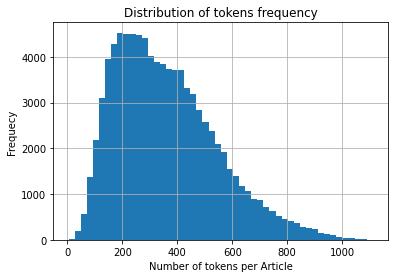

In [ ]:
data[["article_word_count"]].hist(bins = 50)
plt.xlabel("Number of tokens per Article")
plt.ylabel("Frequecy")
plt.title("Distribution of tokens frequency")
plt.show()

In [ ]:
data[["article_word_count"]].describe()

,article_word_count
count,90666.000000
mean,360.133799
std,183.853217
min,4.000000
25%,216.000000
50%,333.000000
75%,473.000000
max,1112.000000


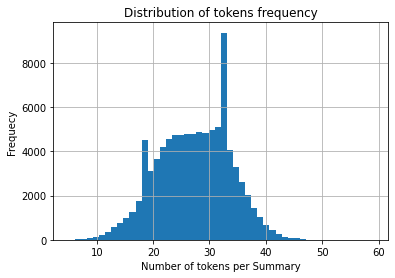

In [ ]:
data[["summary_word_count"]].hist(bins = 50)
plt.xlabel("Number of tokens per Summary")
plt.ylabel("Frequecy")
plt.title("Distribution of tokens frequency")
plt.show()

In [ ]:
data[["summary_word_count"]].describe()

,summary_word_count
count,90666.000000
mean,27.301182
std,6.428527
min,5.000000
25%,23.000000
50%,27.000000
75%,32.000000
max,59.000000


## Preparing dataset

We will truncate the articles and summaries by keeping a maximum number of 475(about third quartile) first terms for the articles and 32 for the summaries.

In [ ]:
encoder_maxlen=475
decoder_maxlen=32
num_art = tf.keras.preprocessing.sequence.pad_sequences(num_art, maxlen=encoder_maxlen, padding='post', truncating='post')
num_summ = tf.keras.preprocessing.sequence.pad_sequences(num_summ, maxlen=decoder_maxlen, padding='post', truncating='post')

In [ ]:
num_art.shape

(90666, 475)

In [ ]:
num_summ.shape

(90666, 32)

In [ ]:
num_art = tf.cast(num_art, dtype=tf.int32)
num_summ = tf.cast(num_summ, dtype=tf.int32)

We will create a TensorFlow dataset from the articles and summarires tensors using TensorFlow’s Dataset API for faster computation.

In [ ]:
Summarization_data = tf.data.Dataset.from_tensor_slices((num_art, num_summ)).shuffle(5000).batch(64)
type(Summarization_data)

tensorflow.python.data.ops.dataset_ops.BatchDataset

Now, we create the positional encodings of the transformers which give information about the position and order of words, in other words the semantics of a sentence. 

#Modelling

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates
  
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

Next is the padding step.
\
Padding mask ignores the external padding added to sequences that are shorter than the maximal length.
\
Look-ahead mask is responsible for ignoring the words that occur after a given current word in the target sequence.

In [ ]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]

  
def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask

Now, we ca build our model.
\
Let's start with the scaled dot product attention which calculates the attention weights from tree inputs: Q (query), K (key), V (value). The equation used to calculate the attention weights is:
\
$Attention(Q, K, V)$ = $softmax(\frac{Q.K^T}{\sqrt{d_k}}).V$




In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  #q, k, v must have matching leading dimensions.
  #k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.

    #q: query shape == (..., seq_len_q, depth)
    #k: key shape == (..., seq_len_k, depth)
    #v: value shape == (..., seq_len_v, depth_v)
    #mask: Float tensor with shape broadcastable to (..., seq_len_q, seq_len_k)
    #Returns output, attention_weights

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)  

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

Point wise feed forward network consists of two fully-connected layers with a ReLU activation in between.

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
        tf.keras.layers.Dense(dff, activation='relu'),
        tf.keras.layers.Dense(d_model)
    ])

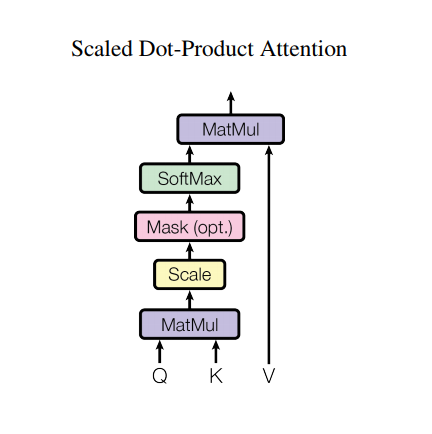

##Multi-headed Attention

### Attention mechanism

Attention is a means of selectively weighting different elements in input data, so that they will have an adjusted impact on the hidden states of downstream layers

###Construction of multi-headed Attention

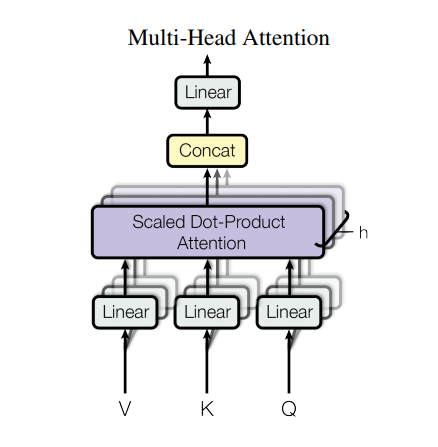

Multi-head attention consists of four parts:
1. Linear layers and split into heads
2. Scaled dot-product attention
3. Concatenation of heads
4. Final linear layer.
\
Each multi-head attention block gets three inputs; Q (query), K (key), V (value). These are put through linear (Dense) layers and split up into multiple heads.

The scaled_dot_product_attention is applied to each head (broadcasted for efficiency). An appropriate mask must be used in the attention step. The attention output for each head is then concatenated (using tf.transpose, and tf.reshape) and put through a final Dense layer.

Instead of one single attention head, Q, K, and V are split into multiple heads because it allows the model to jointly attend to information at different positions from different representational spaces. After the split each head has a reduced dimensionality, so the total computation cost is the same as a single head attention with full dimensionality.

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    #split the last dimension into (num_heads, depth).
    #transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention, 
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

With Multi-Head Attention, we split the inputs into multiple heads in order to compute the attention weights using scaled dot-product attention and finally, concat output from all the heads.

## Encoder and decoder blocks

The encoder layer contains 2 sublayers:
1. Multi-head attention + padding mask
2. Point wise feed forward networks

Each of these sublayers has a residual connection around it followed by a layer normalization. Residual connections help in avoiding the vanishing gradient problem in deep networks.


The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis. There are N encoder layers in the transformer.

In [ ]:
class EncoderLayer(tf.keras.layers.Layer):
  def __init__(self, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = MultiHeadAttention(d_model, num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

A decoder layer consists of 3 sublayers:

1. Masked multi-head attention (with look ahead mask and padding mask)
2. Multi-head attention (with padding mask): V (value) and K (key) receive the encoder output as inputs, and Q (query) receives the output from the masked multi-head attention sublayer.
3. Point wise feed forward networks
Each of these sublayers has a residual connection around it followed by a layer normalization. The output of each sublayer is LayerNorm(x + Sublayer(x)). The normalization is done on the d_model (last) axis.
\
There are N decoder layers in the transformer.

As Q receives the output from decoder's first attention block, and K receives the encoder output, the attention weights represent the importance given to the decoder's input based on the encoder's output. In other words, the decoder predicts the next word by looking at the encoder output and self-attending to its own output.

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        super(DecoderLayer, self).__init__()

        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)
    
    
    def call(self, x, enc_output, training, look_ahead_mask, padding_mask):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask)
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)

        ffn_output = self.ffn(out2)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)

        return out3, attn_weights_block1, attn_weights_block2

As mentionned above, we have N encoder blocks and decoder blocks.
\
In fact, the Encoder consists of:
1. Input Embedding
2. Positional Encoding
3. N encoder layers
\
The input is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the encoder layers. The output of the encoder is the input to the decoder.

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, 
                                            self.d_model)


    self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]

    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

The Decoder consists of:
1. Output Embedding
2. Positional Encoding
3. N decoder layers

The target is put through an embedding which is summed with the positional encoding. The output of this summation is the input to the decoder layers. The output of the decoder is the input to the final linear layer.

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size,
               maximum_position_encoding, rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(maximum_position_encoding, d_model)

    self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate) 
                       for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training, 
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
      attention_weights['decoder_layer{}_block2'.format(i+1)] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

Now after defining the needed functions and classes, we can create our transformer.

## Putting it all together

The transformer is composed of the encoder, decoder and final linear layer which takes the output of the decoder as input and outputs the probabilities 

### The transformer model

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self, num_layers, d_model, num_heads, dff, input_vocab_size, 
               target_vocab_size, pe_input, pe_target, rate=0.1):
    super(Transformer, self).__init__()

    self.encoder = Encoder(num_layers, d_model, num_heads, dff, 
                           input_vocab_size, pe_input, rate)

    self.decoder = Decoder(num_layers, d_model, num_heads, dff, 
                           target_vocab_size, pe_target, rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inp, tar, training, enc_padding_mask, 
           look_ahead_mask, dec_padding_mask):

    enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, dec_padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

In [ ]:
num_layers=4
d_model=128
num_heads=8 
dff=512
input_vocab_size=encoder_vocab_size 
target_vocab_size=decoder_vocab_size 
pe_input=encoder_vocab_size 
pe_target=decoder_vocab_size

transformer = Transformer(
    num_layers=num_layers, d_model=d_model, num_heads=num_heads, dff=dff, 
    input_vocab_size=encoder_vocab_size, target_vocab_size=decoder_vocab_size, 
    pe_input=encoder_vocab_size, pe_target=decoder_vocab_size)

### Learning rate scheduler

This scheduler updates the learning rate in each step

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

learning_rate = CustomSchedule(d_model)

Below is the curve of the evolution of the learning rate

Text(0.5, 0, 'Train Step')

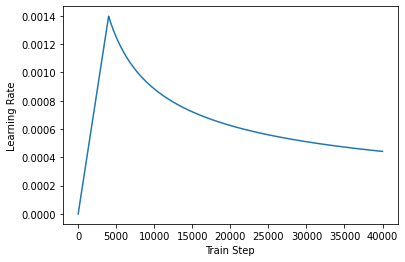

In [ ]:
plt.plot(learning_rate(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

###Optimizer

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98, 
                                     epsilon=1e-9)

### Loss function

CategoricalCrossEntropy loss requires the target as a one-hot encoding of each word. That's why we use SparseCategoricalCrossentropy.
Moreover, we mask the loss incurred by the padded tokens to 0 so that they do not contribute to the mean loss.
\
We add a padding mask when calculating the loss.

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
  
def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)


train_loss = tf.keras.metrics.Mean(name='train_loss')
#train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

### Masks

The masks are used in the attention models of the decoder in order prevent giving attention to future tokens in the sequence.

In [ ]:
def create_masks(inp, tar):
  # Encoder padding mask
  enc_padding_mask = create_padding_mask(inp)

  # Used in the 2nd attention block in the decoder.
  # This padding mask is used to mask the encoder outputs.
  dec_padding_mask = create_padding_mask(inp)

  # Used in the 1st attention block in the decoder.
  # It is used to pad and mask future tokens in the input received by 
  # the decoder.
  look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
  dec_target_padding_mask = create_padding_mask(tar)
  combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

  return enc_padding_mask, combined_mask, dec_padding_mask

### Chekpoints

In [ ]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

Latest checkpoint restored!!


### Train

In [ ]:
# The @tf.function trace-compiles train_step into a TF graph for faster execution. 
# The function specializes to the precise shape of the argument tensors. 
# To avoid re-tracing due to the variable sequence lengths or variable batch sizes (the last batch is smaller), use input_signature to specify more generic shapes.

@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    enc_padding_mask, combined_mask, dec_padding_mask = create_masks(inp, tar_inp)

    with tf.GradientTape() as tape:
        predictions, _ = transformer(
            inp, tar_inp, 
            True, 
            enc_padding_mask, 
            combined_mask, 
            dec_padding_mask
        )
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)    
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    #train_accuracy(accuracy_function(tar_real, predictions))

In [ ]:
EPOCHS = 20

for epoch in range(EPOCHS):
  start = time()

  train_loss.reset_states()
  #train_accuracy.reset_states()

  # inp -> article, tar -> summary
  for (batch, (inp, tar)) in enumerate(Summarization_data):
    train_step(inp, tar)

    if batch % 50 == 0:
      print ('Epoch {} Batch {} Loss {:.4f}'.format(
          epoch + 1, batch, train_loss.result()))

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Epoch {} Loss {:.4f}'.format(epoch + 1, 
                                                train_loss.result()))

  print ('Time taken for 1 epoch: {} secs\n'.format(time() - start))

Epoch 1 Batch 0 Loss 11.2152
Epoch 1 Batch 50 Loss 11.1858
Epoch 1 Batch 100 Loss 11.1128
Epoch 1 Batch 150 Loss 10.9947
Epoch 1 Batch 200 Loss 10.8340
Epoch 1 Batch 250 Loss 10.6391
Epoch 1 Batch 300 Loss 10.4194
Epoch 1 Batch 350 Loss 10.1832
Epoch 1 Batch 400 Loss 9.9432
Epoch 1 Batch 450 Loss 9.7130
Epoch 1 Batch 500 Loss 9.5029
Epoch 1 Batch 550 Loss 9.3215
Epoch 1 Batch 600 Loss 9.1671
Epoch 1 Batch 650 Loss 9.0322
Epoch 1 Batch 700 Loss 8.9101
Epoch 1 Batch 750 Loss 8.7981
Epoch 1 Batch 800 Loss 8.6965
Epoch 1 Batch 850 Loss 8.6017
Epoch 1 Batch 900 Loss 8.5143
Epoch 1 Batch 950 Loss 8.4320
Epoch 1 Batch 1000 Loss 8.3554
Epoch 1 Batch 1050 Loss 8.2827
Epoch 1 Batch 1100 Loss 8.2143
Epoch 1 Batch 1150 Loss 8.1488
Epoch 1 Batch 1200 Loss 8.0875
Epoch 1 Batch 1250 Loss 8.0290
Epoch 1 Batch 1300 Loss 7.9735
Epoch 1 Batch 1350 Loss 7.9195
Epoch 1 Batch 1400 Loss 7.8697
Epoch 1 Loss 7.8541
Time taken for 1 epoch: 954.7222695350647 secs

Epoch 2 Batch 0 Loss 6.4708
Epoch 2 Batch 50 Los

# Evaluation

Now, we define the summarization pipeline to help us predict abstractive summaries

In [ ]:
def evaluate(input_document):
    input_document = article_tokenizer.texts_to_sequences([input_document])
    input_document = tf.keras.preprocessing.sequence.pad_sequences(input_document, maxlen=encoder_maxlen, padding='post', truncating='post')

    encoder_input = tf.expand_dims(input_document[0], 0)

    decoder_input = [summary_tokenizer.word_index["<go>"]]
    output = tf.expand_dims(decoder_input, 0)
    
    for i in range(decoder_maxlen):
        enc_padding_mask, combined_mask, dec_padding_mask = create_masks(encoder_input, output)

        predictions, attention_weights = transformer(
            encoder_input, 
            output,
            False,
            enc_padding_mask,
            combined_mask,
            dec_padding_mask
        )

        predictions = predictions[: ,-1:, :]
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

        if predicted_id == summary_tokenizer.word_index["<stop>"]:
            return tf.squeeze(output, axis=0), attention_weights

        output = tf.concat([output, predicted_id], axis=-1)

    return tf.squeeze(output, axis=0), attention_weights

In [ ]:
def summarize(input_document):
    # not considering attention weights for now, can be used to plot attention heatmaps in the future
    summarized = evaluate(input_document=input_document)[0].numpy()
    summarized = np.expand_dims(summarized[1:], 0)  # not printing <go> token
    return summary_tokenizer.sequences_to_texts(summarized)[0]  # since there is just one translated document

In [ ]:
def check_summary(article, original_summ, synth_summ, synth_summ2,width=100):
  f = lambda text: textwrap.dedent(text).strip()
  #original article
  print("ARTICLE:")
  print(textwrap.fill(f(article), width=width), '\n')
  #summary given by the dataset
  print("ORIGINAL SUMMARY:")
  print(textwrap.fill(f(original_summ), width=width), '\n')
  #summary obtained by threshold method
  print("SUMMARY BY THRESHOLD:")
  print(textwrap.fill(f(synth_summ), width=width), '\n')
  #summary obtained by count method
  print("SUMMARY BY COUNT:")
  print(textwrap.fill(f(synth_summ2), width=width), '\n')

We choose 10 random articles to summarize and check.

In [ ]:
random_list=random.sample(list(data.index), 10)
for i in random_list:
  f = lambda text: textwrap.dedent(text).strip()
  #original article
  print("ARTICLE:")
  print(textwrap.fill(f(data.loc[i,"article_text"]), width=100), '\n')
  #summary given by the dataset
  print("ORIGINAL SUMMARY:")
  print(textwrap.fill(f(data.loc[i,"summary_text"]), width=100), '\n')
  #abstractive summary
  print("ABSTRACTIVE SUMMARY:")
  print(textwrap.fill(f(summarize(data.loc[i,"article_text"])), width=100), '\n')

ARTICLE:
as one of the most anticipated games of 2011 , marvel vs . capcom 3 : fate of two worlds capcom does
not disappoint with new characters , a story line with uber-villain galactus and a new mode designed
to make it easy to get involved in the action . after a 10-year hiatus , the popular fighting game
brings the battle zones into the third dimension . while action remains in two dimensions , the
characters are generated in 3-d and provide for a more robust visual image of the fighting . each
fight can be one-on-one or tag-team , with three characters on each side . one of the biggest
question marks as the game release neared was who would be in and who would be left off of the
marvel and capcom casts . seth killian , special combat adviser for capcom , said the company wanted
to achieve a balance between japanese and western characters . we wanted to include the fan faves
from japan as well as the key characters from marvel , he said . but we also wanted to include some
fringe c

The results are not quit satisfying. It's normal because abstracyive summarization needs very long training process, more multiple heads and more data samples.

We summarize a sample of 1000 articles in order to calculate the scores. Summarizing all of the articles would take too much time.

In [ ]:
random_indexes=random.sample(list(data.index), 1000)
j=0
for i in random_indexes:
  data.loc[i, "abstractive summary"]=summarize(data.loc[i,"article_text"])
  if (j % 100 == 0):
    print(str(j) + "articles summarized")
  j+=1
data.to_pickle("data/data_summarized.pkl")

0articles summarized
100articles summarized
200articles summarized
300articles summarized
400articles summarized
500articles summarized
600articles summarized
700articles summarized
800articles summarized
900articles summarized


In [3]:
with open('data/data_summarized.pkl', 'rb') as f:
  data = pickle.load(f)

We calculate the scores for the predicted summaries

In [8]:
def R_score_abstractive(data, max_n=1, alpha=0.5, score="F1"):
  scores={"F1":"f", "Precision":"p", "Recall":"r"}
  assert(score in scores.keys())
  S=scores[score]
  #set rouge score parameters
  evaluator=rouge.Rouge(metrics = ['rouge-n'], max_n=max_n, alpha=alpha,
                        limit_length = False, stemming=True)
  scores_data=pd.DataFrame()
  index=data[data["abstractive summary"].notnull()].index
  for i in index:
    #reference summary
    ref=data.loc[i, "summary_text"]
    # hypothesis summary
    hyp = data.loc[i, "abstractive summary"]
    data.loc[i, "rouge-score"]= evaluator.get_scores(hyp, ref)['rouge-'+str(max_n)][S]
    scores_data.loc[i, "rouge-score"]= data.loc[i, "rouge-score"]
  return(data, scores_data)

In [9]:
data, scores_data=R_score_abstractive(data)
scores_data.to_pickle("data/abstractive_scores.pkl")

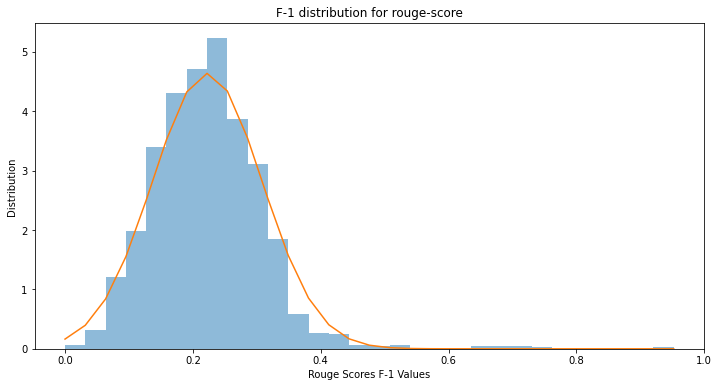

In [10]:
  def plot_distribution_abstractive(scores_data, n_bins=30):
    _, ax = plt.subplots(figsize = (12,6))
    _, bins, _ = plt.hist(scores_data["rouge-score"], n_bins, density=1, alpha=0.5)
    plt.ylabel('Distribution')
    plt.title("F-1 distribution for rouge-score")
    plt.xlabel('Rouge Scores F-1 Values')
    mu, sigma = scipy.stats.norm.fit((scores_data["rouge-score"]))
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    plt.plot(bins, best_fit_line)
    plt.show()
  plot_distribution_abstractive(scores_data)